# 'Seeing' digits: an interpretability dive into MLPs trained on MNIST data

## Part 01. Investigating the importance of normalization

## 0. The why?

My goal is to start digging into some tools used in interpretability. Looking at any paper on the subject we researchers probing the inner layers of models, asking questions like

> What 'features' does the model learn? Do neurons specialize?

Take the Anthropic paper *"Toy Models of Superposition"*, for example — it notes that some models, especially vision models, learn **interpretable features**: neurons that respond to horizontal lines, floppy ears, curves, and so on. These are patterns that we can understand, and when a neuron cleanly represents such a pattern, we call it interpretable. The goal-broadly-will be to interpret (understand) the black box of neural networks. But before that, the question that we hope to start working towards in this notebook is how do we begin to understand what neurons are specializing in? How do we ask what individual neurons look for in the data, and how do we study the specifics of the model as training evolves. We need to build an *interpretability toolbox* that will allow us to address these questions, and ultimately aid in our interpretation of other projects/repos that we have in the pipeline. 



---
**Interpretability tools** This notebook will just be scratching the surface but towards the goal of understanding neural networks we need to be able to 'probe' inner layers and neurons to 'see' how they respond during training and eventually to understand what they are looking for in the data. We begin by asking basic questions, like those raised in Karpathy’s Zero-to-Hero series:
- how does data normalization (or rather non-normalization) affect model behavior?
- What happens to hidden layer activations during training?
- Do neurons become inactive (“dead”) or oversaturated? (moving this to the next notebook)

From there, we'll get into tools like:
- Activation histograms and sparsity analysis
- Gradient tracking
- PCA or t-SNE on hidden representations
- Class-wise activation probing


---
**Notebook plan** (for now)
1) The first thing we do (in notebook 01) is attempt to understand the most naive (baseline) approach: take non-normalized MNIST data and run it through an MLP. What happens to the activations in the hidden layers? Specifically we study the statistics using histograms to aid in our understanding.
2) In notebook 02 we continue probing the model in both forward and backward passes (via hooks). Ask about possible neuron death due to raw data and drifting means/growing variance. 
3) In notebook 03 we will normalize the data and see how the model improves (if it does). Once we have a solid MLP where the activation statistics do not fluctuate too much through the training evolution we set our sights on more specific interpretability tools: gradient tracking, activation heatmaps/trajectories, PCA/t-SNE, etc.
4) We may then compare both normalized, and un-normalized setups to see/understand how tweaking the data (and the model) helps the model specialize.
5) In notebook 04 we will try the same with a CNN where we expect the spacial model to do much better but also (hopefully) be much more interpretable.


---
**Why MNIST**? There are many reasons to start here and they might not seem overly 'sexy' given the state of the art but I think it is a useful dataset to work on and is very natural starting place once we understand MLPs: 
1) MNIST is arguably one of the most basic training examples and one that we understand fairly well
2) MLPs perform fairly well on this dataset but with vectorized data there might be more space for vague interpretability
3) CNNs are the spacial models that seem to specialize a bit more and hence should be more clearly interpretable
4) We ended our [Micrograd experimentation](https://github.com/eriktholmes/Zero-to-hero-course/tree/main/episode-1/experiments/MNIST) with the MNIST data so why not pick up there!?

## 1. Overview/goals

This notebook is the first in a multi-part interpretability exploration. Here, we focus solely on a baseline MLP trained on non-normalized MNIST data, and we ask:

> - What happens to internal activations during training?
> - How do statistics like mean and standard deviation evolve layer-by-layer?
> - Do we observe signs of saturation, instability, or neuron death?
> - Are these effects uniform across digits, or are some classes more chaotic than others?

To answer these questions, we log and visualize:

> - Layerwise activations (histograms across training epochs)
> - Mean/std drift for all data as well as specific class (digit) data
> - Early signs of saturation or instability before normalization is introduced\
> ...No PCA, CNNs, or advanced probing tools are introduced yet — the goal is to establish an empirical baseline that later tools will be compared against.

***Disclaimer** I don’t claim to be an expert on these tools yet, but part of the point is to learn by doing, document that process, and build a foundation I can use in future projects. Once the MLP is running I’ll upgrade to a CNN (likely in a different notebook) to see what kinds of differences emerge, both in performance and (hopefully) in how the network learns to represent digits.*

## 2. MNIST data

### Section 2: Overview
We will proceed as follows:

**2.1.** Download and batch data (without normalization): the goal of this step is to have a baseline to compare future experiments\
**2.2.** Investigate statistics before training: **Raw input mean**: 0.1307, **Raw input std**: 0.3015. \
We also include some histograms of the raw data to accompany these statistics: there is a lot of white space in these images so we expect big peaks in the hisstograms near 0, and again near 1. We also expect different distributions based on digits (there is less marking for a '1' than for a '0' or '8') so we specialize this approach to individual digits as well. We will use this in the following sections to see if our model does better with certain digits than others. 
> **Visualizations**
>  1) histogram of pixel data for first 1000 training examples
>  2) histogram of pixel data based on digit
>  3) bar chart of mean pixel data per digit
>  4) mean $\pm$ std per digit


### 2.1. MNIST data download/batching

In [36]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 2.2. Some statistics/visualizations

In [54]:
means = []
stds = []

for xs, _ in train_loader:
    xs = xs.view(xs.size(0), -1)
    means.append(xs.mean(dim=1))
    stds.append(xs.std(dim=1))

all_means = torch.cat(means)
all_stds = torch.cat(stds)

print(f'Raw input mean: {all_means.mean():.4f}')
print(f'Raw input std: {all_stds.mean():.4f}')

Raw input mean: 0.1307
Raw input std: 0.3015


#### 2.3. Visualizations

#### First, we visualize the actual pixel data distributions for the first 1000 examples
1) We create a list of all pixel data for the first 1000 images
2) We create a dictionary of lists based on label to see if there is a difference in pixel distributions
3) We plot each of the above to visualize the distributions

In [40]:
# Want to gather some actual data for plotting purposes. 
# 1. We will collect all the pixel data
# 2. We collect pixels data based on digits

all_pixels = []
digit_pixels = {i: [] for i in range(10)}
count = 0

for x, y in train_dataset:
    count += 1
    x = x.view(-1)
    all_pixels.append(x)

    digit_pixels[y].append(x.view(-1))

    if count >= 1000:
        break

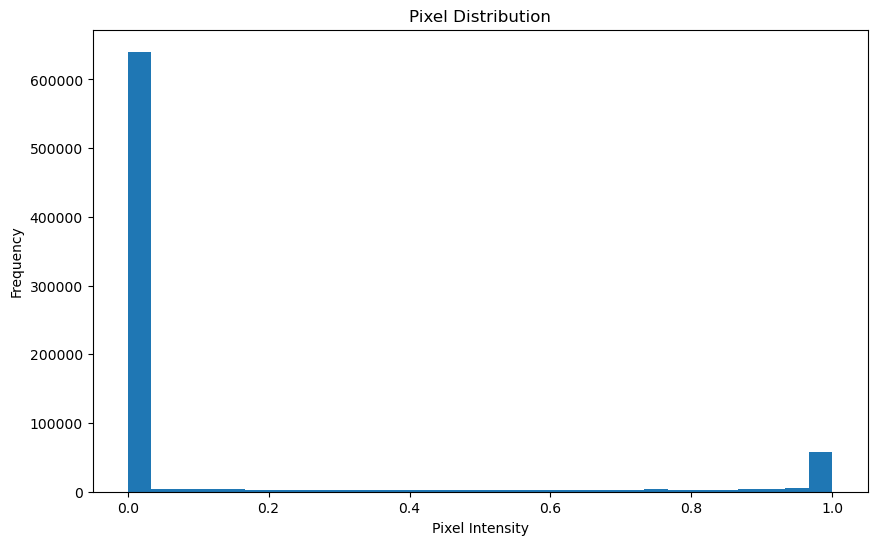

In [46]:
import matplotlib.pyplot as plt

# Take the pixels list and concatenate to create a single 1D tensor
all_pixel_data = torch.cat(all_pixels, dim=0).view(-1)

plt.figure(figsize=(10, 6))
# Plot the data using a histogram with 30 bins
plt.hist(all_pixel_data.numpy(), bins=30)
plt.title("Pixel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

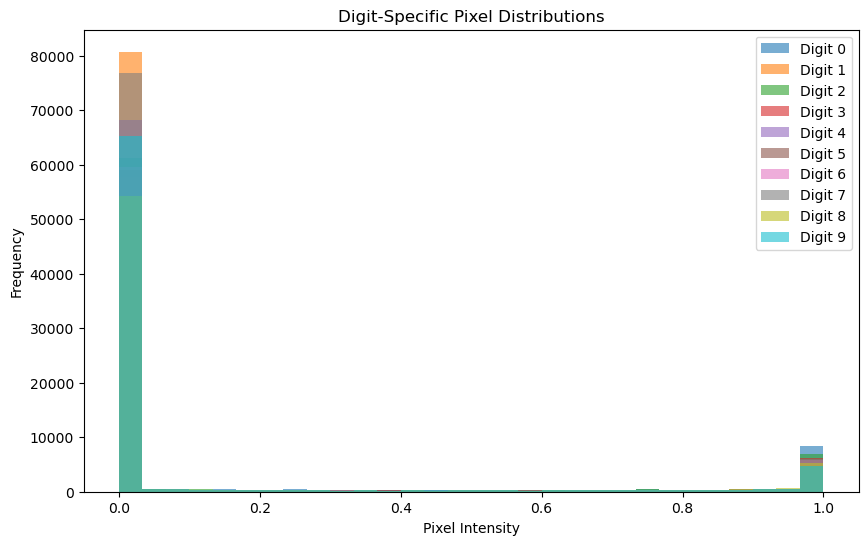

In [48]:
# Now, we do the same but with our digit specific data (we just want to see the differences in pixel distributions... there should be some!)
plt.figure(figsize=(10, 6))
means = []
stds = []
for i in range(10):
    digit_pixel_data = torch.cat(digit_pixels[i], dim=0).view(-1)
    plt.hist(digit_pixel_data.numpy(), bins=30, alpha=0.6, label=f'Digit {i}')
    means.append(digit_pixel_data.mean().item())
    stds.append(digit_pixel_data.std().item())
    
plt.title("Digit-Specific Pixel Distributions")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

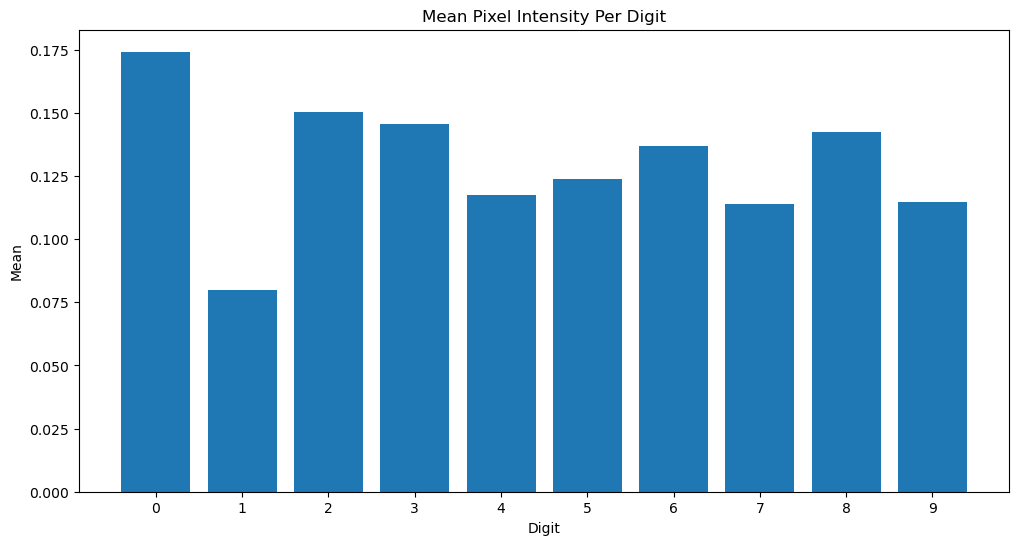

In [50]:
plt.figure(figsize=(12,6))
plt.bar(range(10), means)
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Mean Pixel Intensity Per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean")
plt.show()

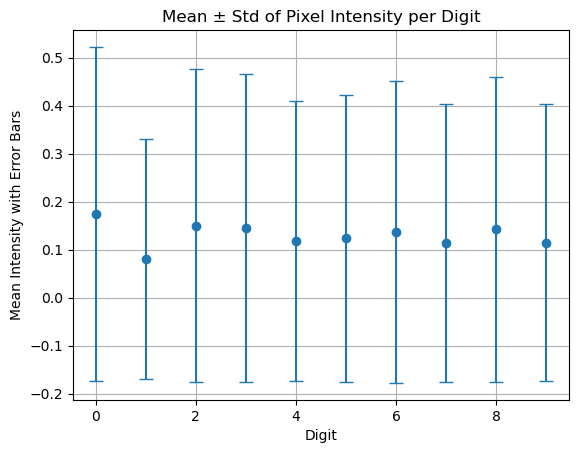

In [52]:
plt.errorbar(range(10), means, yerr=stds, fmt='o', capsize=5)
plt.title("Mean ± Std of Pixel Intensity per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean Intensity with Error Bars")
plt.grid(True)
plt.show()

## 3. Building an interpretable MLP and training our digit classifier (w/o normalization)

### Section 3: Overview
<!--*This sections works on the model without normalizing the data for comparison purposes*\-->
**3.1.** Build model\
**3.2.** Train model and track activations in layer 1 through training (after 20 epochs)\
    - **Loss**: 0.1437, **Accuracy**: 94.94%\
**3.3.** Test model\
    - **Accuracy**: 95.07%\
**3.4.** Train model again with activation tracking throughout the model (layer1, relu1, layer2, relu2, final logits)

### 3.1. Basic (2 hidden layer) MLP with ReLU activation
We attempt to make this as 'interpretable' as possible so we are doing things very simply and making sure we can grab data as we go: i.e. by adding ```self.___#``` in the forward pass we are able to pluck out activations for analysis during training. In the future (below) sections we will do this in a more streamlined way using hooks so we can also track gradients.\
*Note to self: the paper ***Extracting and visualizing hidden activations and computational graphs of PyTorch models with TorchLens*** provides some motivation.*

In [56]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16,10)

    def forward(self, x):
        self.linear1_out = self.linear1(x)
        self.act1 = self.relu1(self.linear1_out)
        self.linear2_out = self.linear2(self.act1)
        self.act2 = self.relu2(self.linear2_out)
        self.logits = self.output(self.act2)
        return self.logits

### 3.2. Training (visualizing layer 1 activations)

In [58]:
import torch

seed = 31416
torch.manual_seed(seed)


model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activation_log = {'layer1': []}

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activation_log['layer1'].append(model.linear1_out.detach())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.7227, Accuracy: 44.3167%
Epoch 5 — Loss: 0.3368, Accuracy: 90.4050%
Epoch 10 — Loss: 0.2477, Accuracy: 92.9117%
Epoch 15 — Loss: 0.1990, Accuracy: 94.2500%


#### A helpful function for the next few sections/examples

In [60]:
def activation_viz(layer, list, title):
    plt.figure(figsize=(12, 6))
    for i in list:
        data = layer[i].flatten().numpy()
        plt.hist(data, bins=30, alpha=0.6, label=f'Epoch {i}')
    plt.title(f"{title} Activation Distributions")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

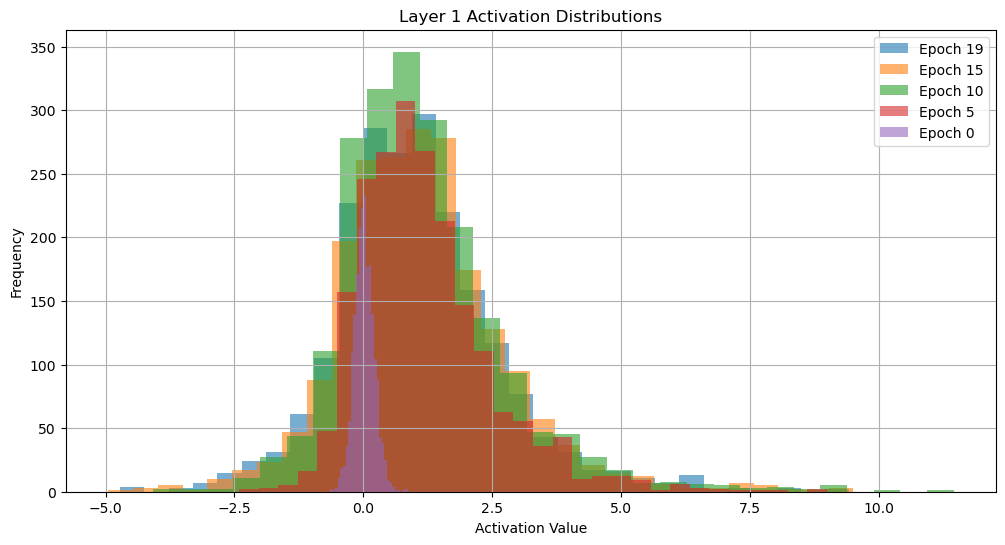

In [62]:
epochs_to_plot = [0 , 5, 10, 15, 19]

activation_viz(activation_log['layer1'], reversed(epochs_to_plot), 'Layer 1')

#### Quick thoughts
Even in the first layer, we see activations quickly spreading out — the histogram fanning out after just a few training steps - I reversed the epoch order here to make this more apparent. While the model still reaches decent accuracy on raw data (and test data), these unnormalized activations suggest poor calibration which would likely cause much more dramatic failure in deeper models. 

In short: non-normalized inputs lead to increasingly extreme activations, layer after layer. This fanning out is a recipe for vanishing or exploding gradients in deeper nets — and often means less stable learning overall.

Below, we’ll compare this to the normalized version, where activations are (hopefully :fingerscrossed) more compact.

### 3.3. Testing the model

In [64]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for xs, ys in test_loader:
        xs = xs.view(xs.size(0), -1)
        yout = model(xs)
        preds = torch.argmax(yout, dim=1)
        correct += (preds == ys).sum().item()
        total += ys.size(0)

print(f"Test Accuracy: {(correct / total)*100:.4f}%")

Test Accuracy: 94.8000%


### 3.4. Tracking all activations

In [68]:
from collections import defaultdict

seed = 31416
torch.manual_seed(seed)

model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activations_log = defaultdict(list)

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activations_log['linear1'].append(model.linear1_out.detach().flatten())
            activations_log['act1'].append(model.act1.detach().flatten())
            activations_log['linear2'].append(model.linear2_out.detach().flatten())
            activations_log['act2'].append(model.act2.detach().flatten())
            activations_log['logits'].append(model.logits.detach().flatten())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.7227, Accuracy: 44.3167%
Epoch 5 — Loss: 0.3368, Accuracy: 90.4050%
Epoch 10 — Loss: 0.2477, Accuracy: 92.9117%
Epoch 15 — Loss: 0.1990, Accuracy: 94.2500%


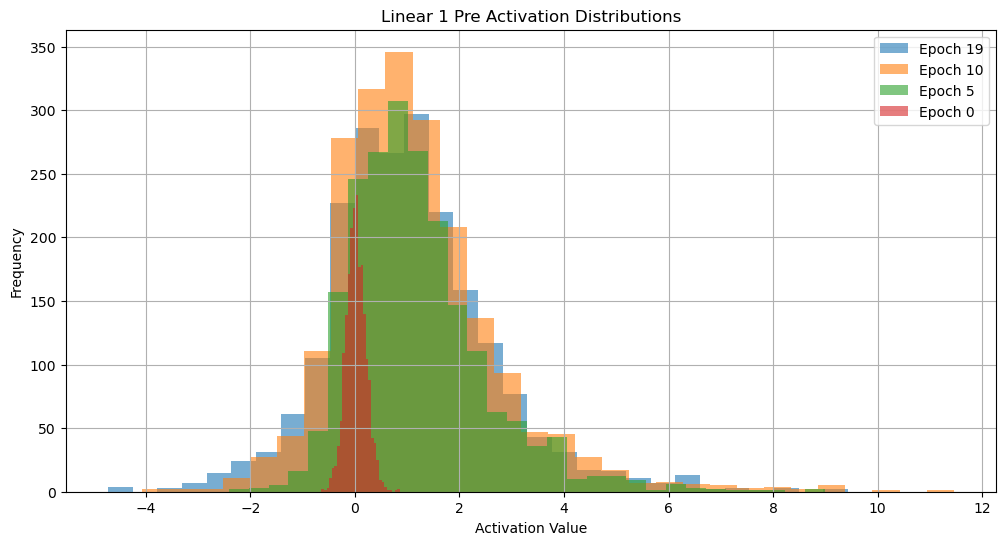

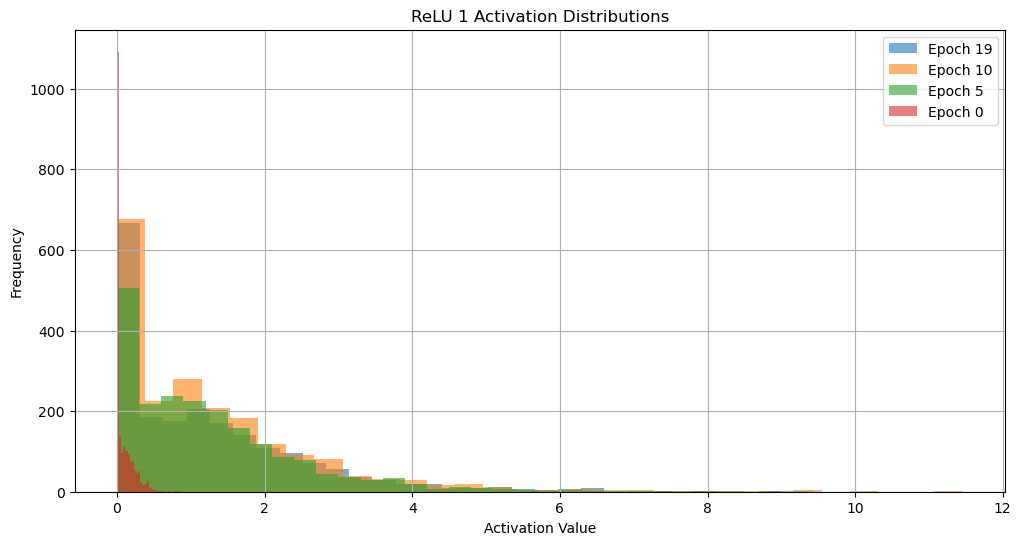

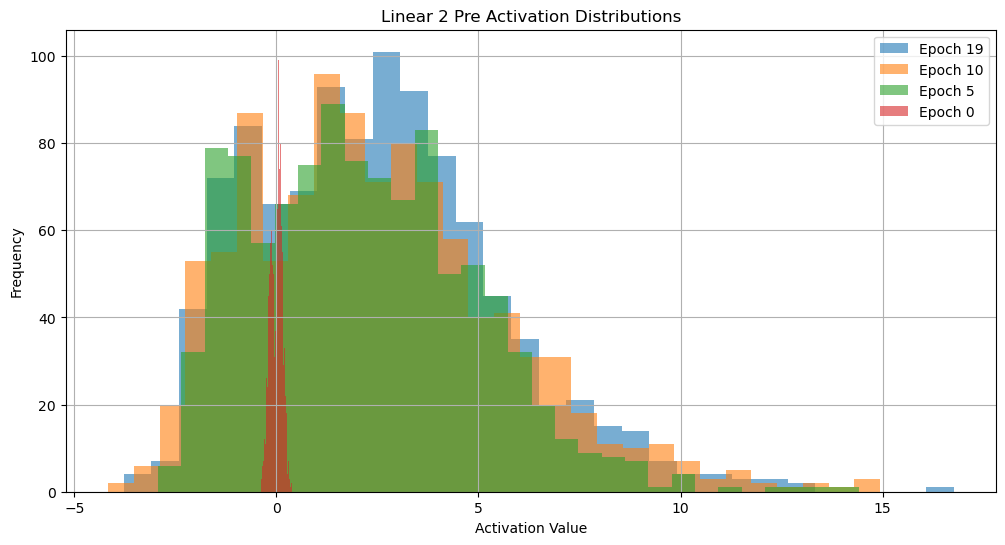

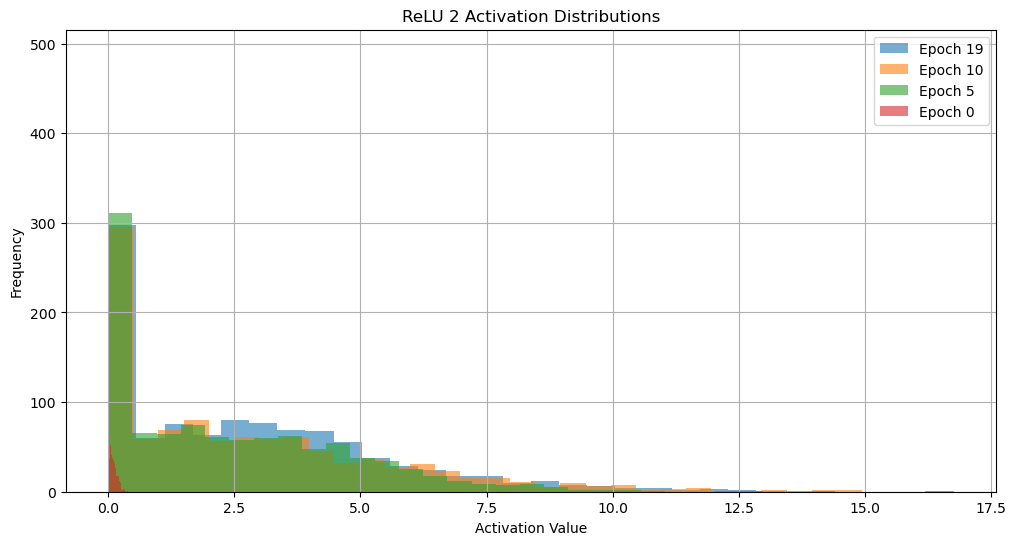

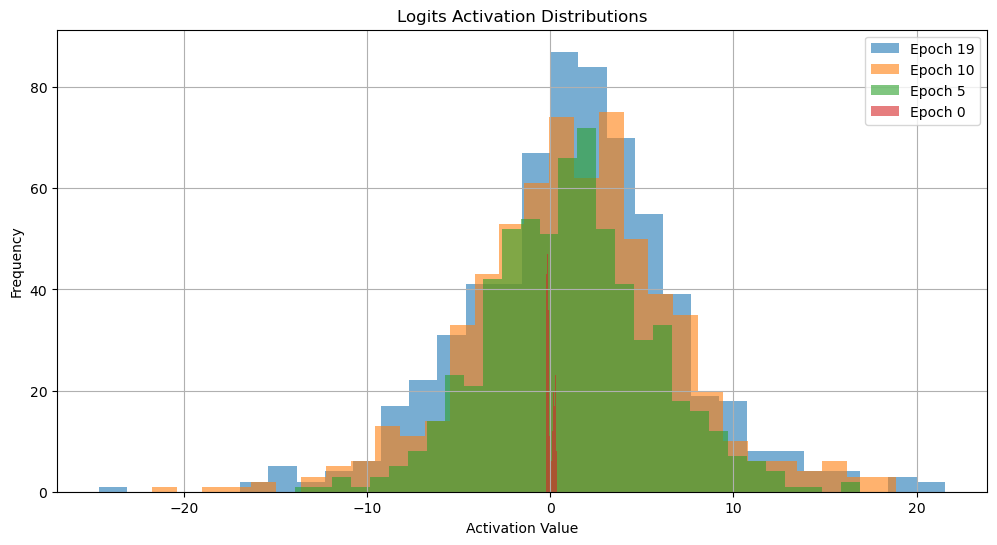

In [70]:
epochs_to_plot = [19, 10, 5, 0]
activation_viz(activations_log['linear1'], epochs_to_plot, "Linear 1 Pre")
activation_viz(activations_log['act1'], epochs_to_plot, "ReLU 1")
activation_viz(activations_log['linear2'], epochs_to_plot, "Linear 2 Pre")
activation_viz(activations_log['act2'], epochs_to_plot, "ReLU 2")
activation_viz(activations_log['logits'], epochs_to_plot, "Logits")

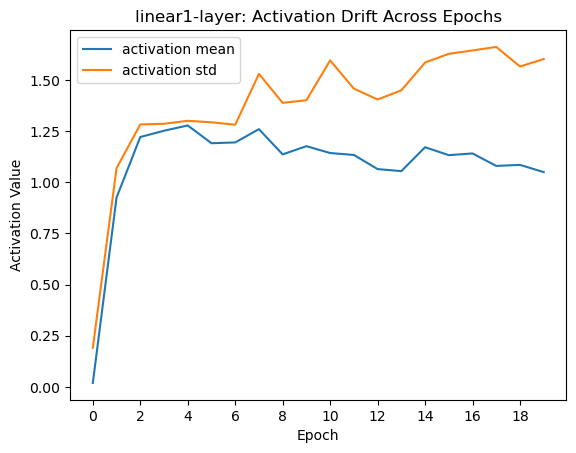

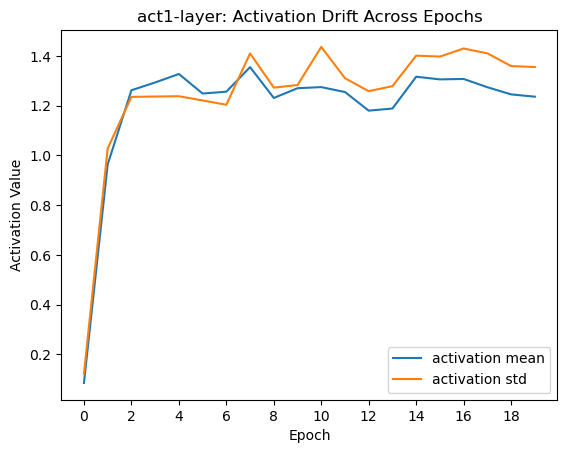

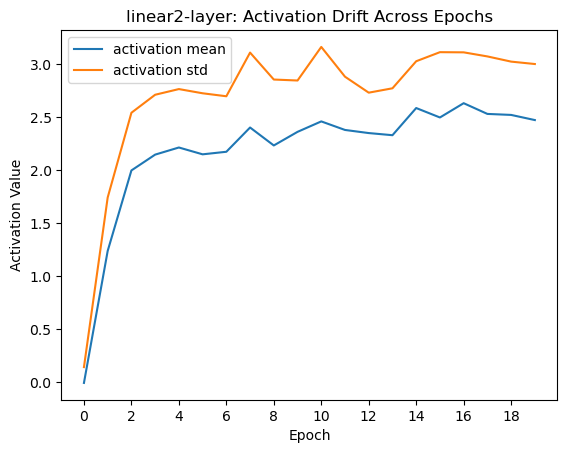

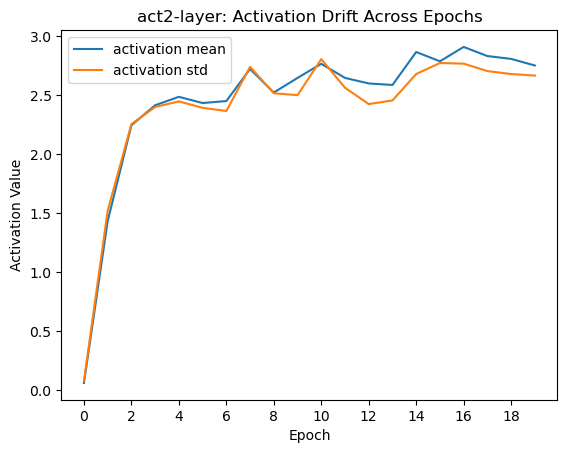

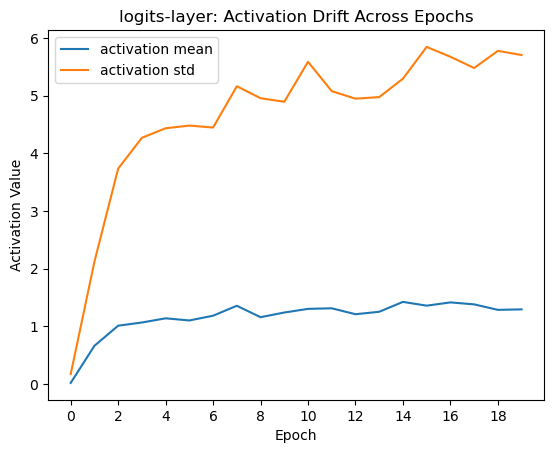

In [72]:
for layer in ['linear1', 'act1', 'linear2', 'act2', 'logits']:
    act = layer
    epoch_means = []
    epoch_stds = []
    
    for i in range(20):
        epoch_means.append(activations_log[act][i].mean().item())
        epoch_stds.append(activations_log[act][i].std().item())
        #print(f'Epoch {i}: mean-{layer1_class_act[5][i].mean().item():.2f}, std-{layer1_class_act[5][i].std().item():.2f}')
    
    
    plt.plot(epoch_means, label="activation mean")
    plt.plot(epoch_stds, label="activation std")
    plt.title(f"{act}-layer: Activation Drift Across Epochs")
    plt.xticks([2*i for i in range(10)])
    plt.xlabel("Epoch")
    plt.ylabel("Activation Value")
    plt.legend()
    plt.show()
    plt.close()

### 3.5. Further reflections

Above we analyzed the distribution of activations across the entire forward pass, from the first hidden layer to the final logits. To highlight how the model’s internal representations evolve, we compare only the first, fifth, and final training epochs, which makes the change in distribution especially clear.

So again, even though we achieve reasonable performance on the test set the internal activations show how unstable the training process is.

Before moving on to normalization, let’s ask a couple more questions:

> 1) What about neuron death?  
> 2) What happens when we focus on specific classes (digits)?

The latter question should help us determine if this is a global issue (affecting all digits) or if it is really a local issue (affecting some classes more than others). We are drawn to this question because we did see some differences in the distribution across classes from section 2. 

### 3.6. Where do we fail!? 
Before moving on, let's just quickly look at some of the examples where our model fails.

In [74]:
correct = 0
total = 0

failures = []

with torch.no_grad():
    for img, y in test_dataset:
        total += 1
        x = img.view(-1, 28*28)
        yout = model(x)
        pred = torch.argmax(yout, dim=1)
        if pred == y:
            correct += 1
        else:
            failures.append((img, y, pred))

print(f'The model acheives {correct/total * 100: .2f}% accuracy on the test set... below we see some failures in the predictions')

The model acheives  94.80% accuracy on the test set... below we see some failures in the predictions


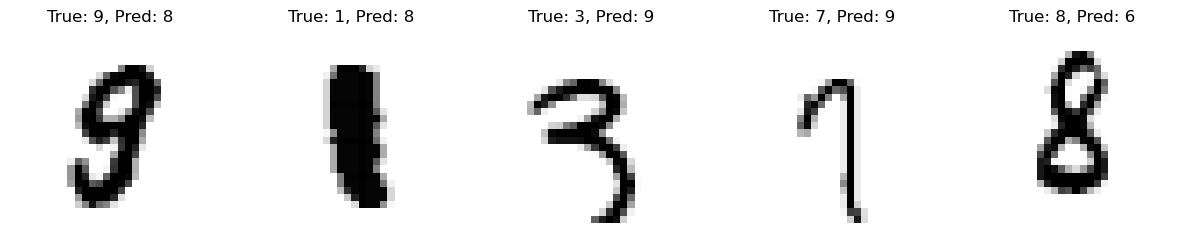

In [76]:
import matplotlib.pyplot as plt

ind = torch.randint(0, len(failures), (5,))

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for ax, i in zip(axes, ind):
    img, label, pred = failures[i.item()]
    ax.imshow(img.squeeze(), cmap='gray_r')
    ax.set_title(f'True: {label}, Pred: {pred.item()}')
    ax.axis('off')
plt.show()

#### Thoughts:
We can see that this is not great! In previous MNIST experiments (before the creation of this notebook) the failures we saw were a little more understandable. We hope the models predictions improve as we fine tune it a bit in future notebooks. 

## 4. Class based analysis

### 4.1. Class analysis

In [80]:
from collections import defaultdict

seed = 31416
torch.manual_seed(seed)


class_act = defaultdict(list)
layer1_class_act = defaultdict(list)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0

    for count, (xs, ys) in enumerate(train_loader):
        yout = model(xs.view(xs.size(0), -1))
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        # Log activations from layer1 for one batch only
        #if count == 0:
        layer1_pre_activations = model.linear1_out.detach()  # shape: (batch_size, neurons)
        
        for act, label in zip(layer1_pre_activations, ys):
            class_act[label.item()].append(act)
    for k in class_act:
        layer1_class_act[k].append(torch.stack(class_act[k]).flatten())
        class_act[k] = []
            #for act, label in zip(layer2_post_activations, ys):
            #    class_act[label.item()].append(act)

    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.7227, Accuracy: 44.3167%
Epoch 5 — Loss: 0.3368, Accuracy: 90.4050%
Epoch 10 — Loss: 0.2477, Accuracy: 92.9117%
Epoch 15 — Loss: 0.1990, Accuracy: 94.2500%


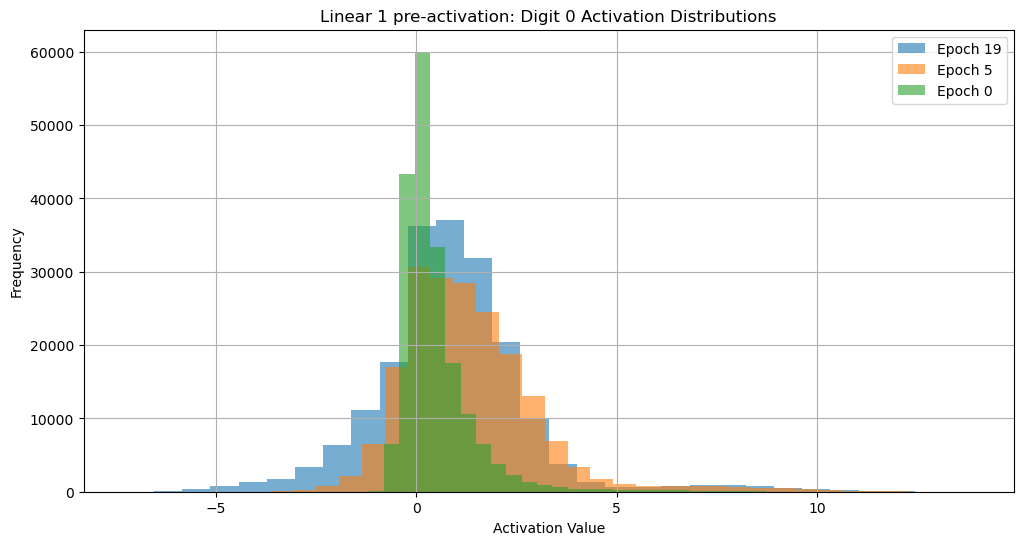

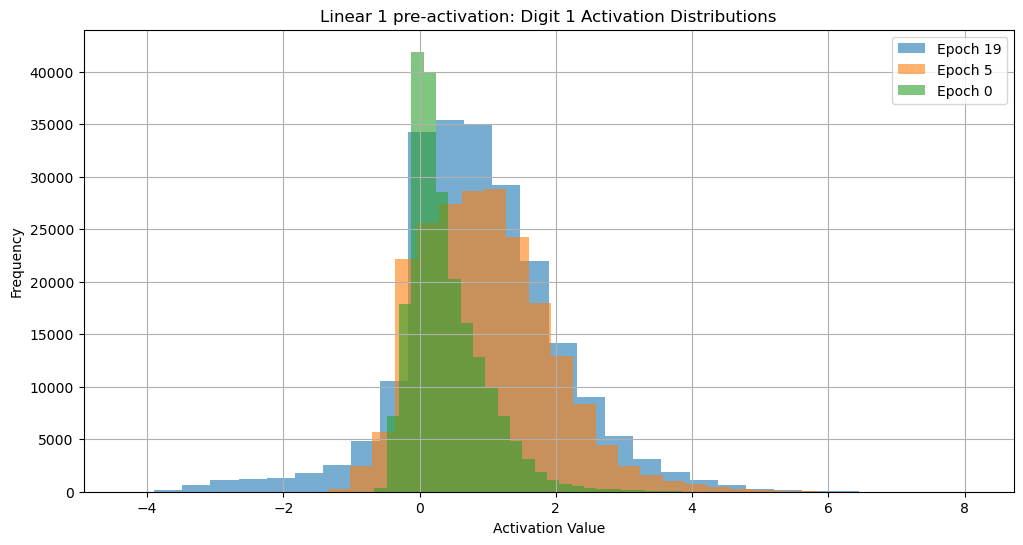

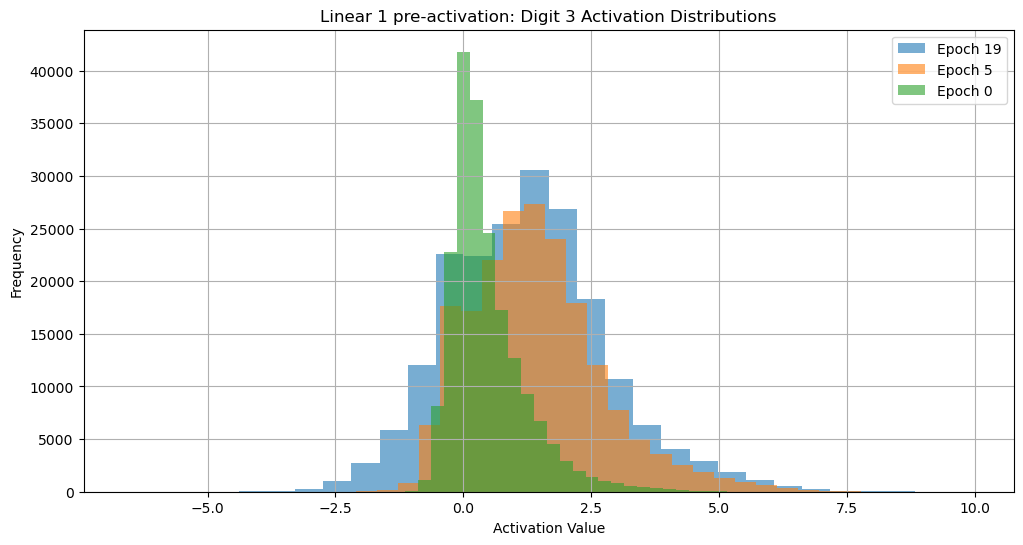

In [88]:
# Here we look at the pre-activation histograms of layer 1 over training

classes = [0, 1, 3]

for cl in classes:
    activation_viz(layer1_class_act[cl], [19, 5, 0], f"Linear 1 pre-activation: Digit {cl}")

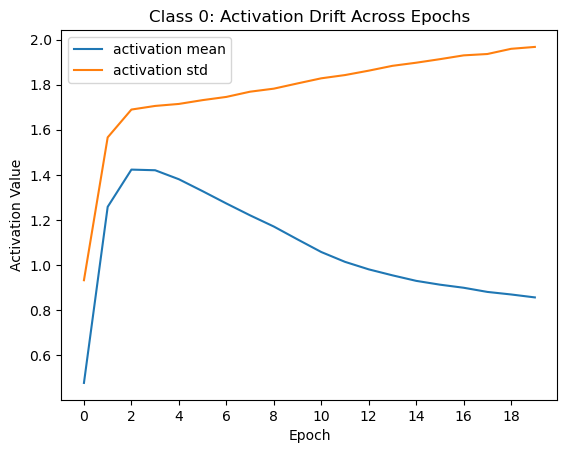

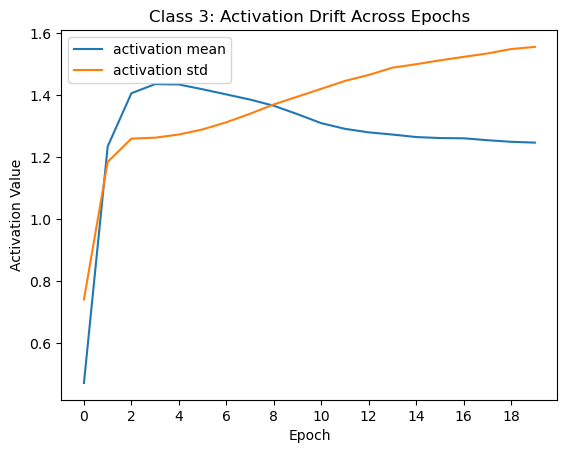

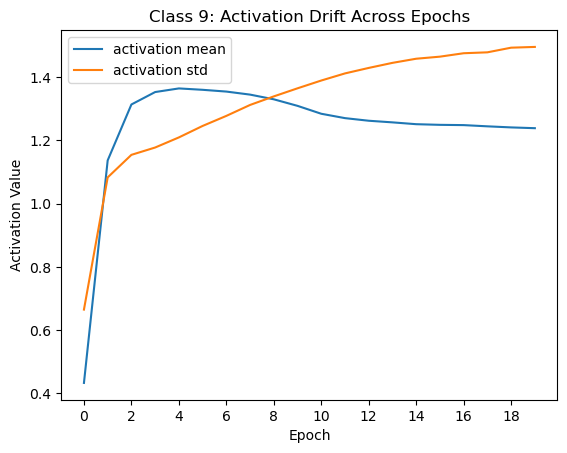

In [92]:
for cl in [0, 3, 9]:
    ex_class = cl
    class_epoch_means = []
    class_epoch_stds = []
    
    for i in range(20):
        class_epoch_means.append(layer1_class_act[ex_class][i].mean().item())
        class_epoch_stds.append(layer1_class_act[ex_class][i].std().item())
        #print(f'Epoch {i}: mean-{layer1_class_act[5][i].mean().item():.2f}, std-{layer1_class_act[5][i].std().item():.2f}')
    
    
    plt.plot(class_epoch_means, label="activation mean")
    plt.plot(class_epoch_stds, label="activation std")
    plt.title(f"Class {ex_class}: Activation Drift Across Epochs")
    plt.xticks([2*i for i in range(10)])
    plt.xlabel("Epoch")
    plt.ylabel("Activation Value")
    plt.legend()
    plt.show()
    plt.close()

#### Quick recap
Okay, what we are doing above is capturing the activations of layer 1 based on a fixed class (e.g., digit "3") and plotted a histogram of these activations for various epochs. We again see the similar 'fanning out' issue for each digit, though we do see some seemingly different distributions/spreads.

To better understand how our non-normalized MLP evolves during training, we tracked the mean and standard deviation of activations in the first hidden layer across 20 epochs. Across classes we observe:
> - mean quickly increases (from ~.3 to ~1.5) before gradually declining. Note this this depends a bit on the class, though we do see a similar trend for each
> - the standard deviation, however, seems to increase throughout the epochs, even as the mean seems to stabilize

This tells us that even though the model was training “successfully” in terms of test accuracy (~94%), the internal representations were becoming increasingly unstable. The distribution of activations was not just drifting—it was spreading. This growing variance likely has cascading affects as the models get deeper and therefore we have excellent evidence for normalization (if we needed any extra motivation for this anyway!).




## 5. Output visualizations: PCA/t-SNE/UMAP

In the previous section we saw hints at seemingly 'important' neurons across the hidden layers and we could start to infer behavior of our network using various visualizations. While this was interesting, and we hope more fruitful when normalization enters the picture, we figured the best thing to do now was to use some dimension reduction techniques for a few reasons... to
1) explore these ideas/techniques in a very simple setting
2) visualize (roughly) what activation space looks like in hidden layers.
3) see whether the neurons are learning 'class-separating' features, are classes clustered in obvious ways?
4) etc.
Towards this, lets dive in:

### 5.1. Class based accuracy

Since we are going to be visualizing activation representations by class and hope to see cleanly separated classes (or at least observe obvious interactions) we start with our models accuracy across classes. We will reference this below where we analyze roughly what we see in the visualizations

In [109]:
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_accuracy = defaultdict(float)

model.eval()
with torch.no_grad():
    for x,y in test_dataset:
        out = model(x.view(-1, 28*28))
        pred = torch.argmax(out, dim=1)
        if pred.item() == y:
            class_correct[y] += 1
        class_total[y] += 1


for i in range(10):
    class_accuracy[i] = class_correct[i]/class_total[i]*100

descending_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

print('Ordered (per-class) accuracy')
print('----------------------------')
for i in range(10):
    print(f"Model accuracy on class {descending_accuracy[i][0]}: {descending_accuracy[i][1]:.2f}%")


Ordered (per-class) accuracy
----------------------------
Model accuracy on class 0: 98.27%
Model accuracy on class 1: 97.89%
Model accuracy on class 6: 95.51%
Model accuracy on class 2: 95.06%
Model accuracy on class 4: 94.91%
Model accuracy on class 7: 94.55%
Model accuracy on class 5: 94.28%
Model accuracy on class 8: 92.61%
Model accuracy on class 9: 92.37%
Model accuracy on class 3: 92.18%


### 5.1. PCA

#### 5.1.0 Prelude

Principal Component Analysis (PCA) is a *linear* dimension reducing technique that shows up frequently in interpretability research. At its core, it helps us reduce the dimension of a learned representation space so that we can visualize it.

In machine learning — and mathematics — the spaces we work in are often absurdly high-dimensional and hard (impossible?.. for me at least) to visualize directly. So we use to tools like PCA to project these spaces down to something more reasonable for us meremortals-usually 2D or 3D. In my (mathematical) research, I regularly use similar projection techniques to explore complicated structures (if interests are peaked, see the aside below!) but this will be my first time applying PCA to neural network activations, so I’m excited to see what the results look like.


#### 5.1.1 PCA Overview

The basic idea of PCA is to take some high-dimensional data (like the hidden layer activations of a neural network) and find a new set of features (i.e. principal components) that capture as much of the original variation as possible.

To do this, we use linear algebra (woot woot):

1) We start by computing the covariance matrix of the data, which tells us how different features vary/influence each other.
2) We then compute the eigenvalues and eigenvectors of this covariance matrix.
    - The eigenvectors are the principal components: new axes or directions that form an orthogonal basis (i.e. basis vectors form a rectangle in 2D and in general they form a [cuboid](https://en.wikipedia.org/wiki/Cuboid) or *right-rectangular prism*).
    - The eigenvalues tell us how important each direction is — i.e. how much of the data’s variation it explains.
3) We sort the components by importance and project our data onto the top $k$ components, often just 2 for visualization (as below).

**The result**: a (2D) projection of the original high-dimensional space that preserves as much structure as possible.


> There are many good references for PCA, but [this one from GeeksforGeeks](https://www.geeksforgeeks.org/principal-component-analysis-pca/) offers a solid, approachable overview for those who prefer to avoid more formal math :shrug.


<p style="margin: auto; background-color:rgba(300, 0, 0, .1); width: 75%;;  border: 1px solid black; padding: .5em">
 <b> A Mathy Aside</b>: My research involves working with high-dimensional matrices — representing lattices — and studying how these representations vary across structured families. Here we often apply such projections to discard the features shared by all lattices, so we can focus on the more interesting differences.<br>
So while PCA in ML might seem different from PCA in math research, they share a deep geometric intuition — one that I find endlessly fascinating. If I occasionally veer off on such tangents, forgive me. I’m just having fun!*
</p>

#### 5.1.2. Performing PCA
1) run the model and gather activations/labels of the penultimate layer.
2) run PCA (thanks to ```sklearn``` this is trivial)
3) plot the results and see what we get!

In [111]:
activations = []
labels = []
model.eval()
with torch.no_grad():
    for x,y in test_dataset:
        x1 = model.linear1(x.view(-1, 28*28))
        x2 = model.relu1(x1)
        x3 = model.linear2(x2)
        x4 = model.relu2(x3)
        activations.append(x4)
        labels.append(torch.tensor([y]))

In [113]:
# concatenate the lists of tensors and covert to numpy array
acts = torch.cat(activations).numpy()
ys = torch.cat(labels).numpy()

In [115]:
from sklearn.decomposition import PCA

Proj = PCA(n_components=2).fit_transform(acts)

In [117]:
# Proj contains the projection of the activations in the last hidden layer onto 2D space via PCA.
# Each entry Proj[i] is a 2D point (x, y) representing example i in the reduced space
Proj[1]

array([-1.5907967,  2.7354128], dtype=float32)

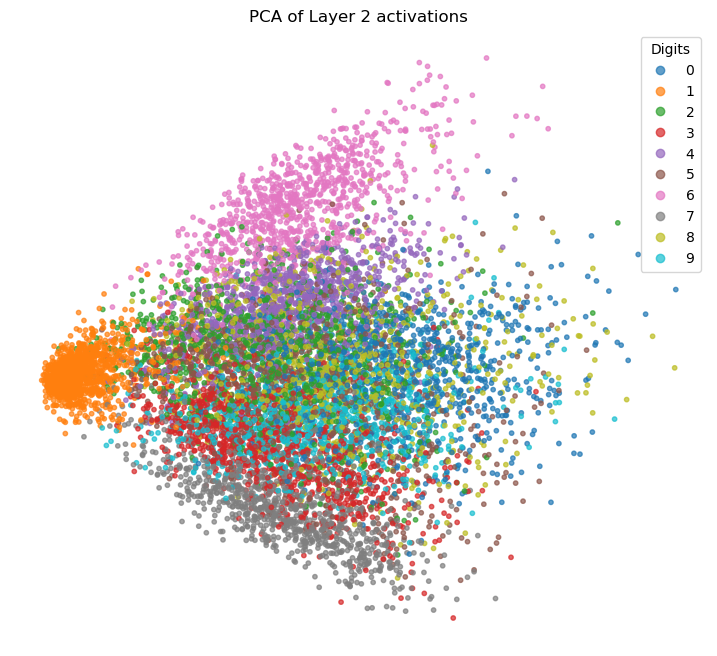

In [119]:
# Plotting:
plt.figure(figsize=(9,8))
scat = plt.scatter(Proj[:, 0], Proj[:, 1], c=ys, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scat.legend_elements(), title="Digits")
plt.title('PCA of Layer 2 activations')
plt.axis('off')
plt.show()

#### 5.1.3. Some observations
I think this is beautiful... Is it what we would hope for in a perfect world? Probably not — the clusters aren't entirely clean, and there's quite a bit of overlap, but it's not random/meaningless noise either. What we're seeing is a network that's learning to detect shared features across digits — and that's quite fun! Consider this:
- When we (or at least when I) write a **4** versus a **9**, the 9 often looks like a 4 with a hat. So it’s no surprise that these two classes appear close together in the PCA plot.
- The digit **7** lacks some of that structure but still shares partial strokes — and we do see it somewhat near 4 and 9, though with more separation.
- Meanwhile, digits like **3, 5, 6, and 8** often share a loopy lower-right structure (amongst other things) — and sure enough, their embeddings cluster near one another.

These aren’t just random coincidences. The model appears to be building an internal feature space where digits with similar substructures are geometrically close.

The digit **1**, on the other hand, is structurally quite unique — and that’s clearly reflected in the visualization. The ones cluster tightly together at the top of the plot and are fairly well-separated from the rest of the other classes, showing the model has likely found a strong, distinct representation for this class. And, as we see above, the accuracy is quite high for this class. 

So... there is a bit of overlap here (unsurprisingly, 3 and 6 seem to have the most significant overlap!) but we do see some pretty clear boundaries! 

> Note: we could/should also try this with the first layer! My assumption is that there would be less clear separation of classes... what do you think??

#### 5.1.4. A quick experiment
Just wanted to 'see' what is looked like if we took the top 5 classes (in terms of accuracy) and projected only those down.

In [121]:
import numpy as np

top_classes = [0,1,6,2,4]
mask = np.isin(ys, top_classes)

Proj_filtered = Proj[mask]
ys_filtered = ys[mask]

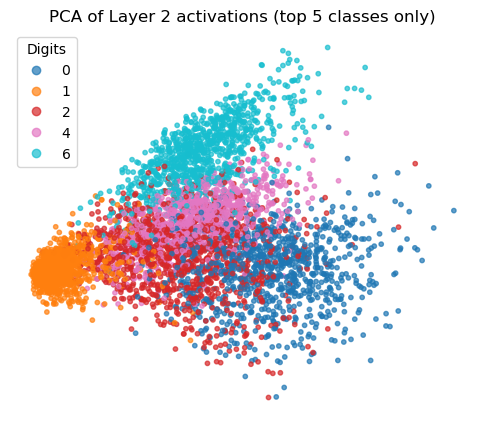

In [123]:
# Plotting:
plt.figure(figsize=(6,5))
scat = plt.scatter(Proj_filtered[:, 0], Proj_filtered[:, 1], c=ys_filtered, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scat.legend_elements(), title="Digits")
plt.title('PCA of Layer 2 activations (top 5 classes only)')
plt.axis('off')
plt.show()

## 5.2. t-SNE

<p style="margin: auto; background-color:rgba(300, 300, 0, .1); width: 50%;;  border: 1px solid black; padding: .5em">
 <b>Recommendation</b>: Just check out the following <a href="https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/">blog post</a>, by Francisco Castillo who provides a really nice summary of these techniques (SNE, t-SNE, and UMAP).  I will follow the very natural format of his post but will only provide a quick summary for future reference.
</p>

### 5.2.0. What is t-SNE?
t-distributed Stochastic Neighbor Embedding, or t-SNE, is another popular dimensionality reduction technique used to map high-dimensional data into low-dimensional (often 2D or 3D) space for visualization.

Unlike PCA, which is a linear method, t-SNE is nonlinear, making it better suited for capturing complex spatial relationships — especially in datasets like MNIST, where high-dimensional activations may lie on [manifolds](https://en.wikipedia.org/wiki/Manifold_hypothesis). Instead of projecting the data directly, t-SNE tries to preserve the local 'neighborhood structure' of each point. That is, if two inputs are “close” in the original space, t-SNE tries to keep them close in the projected space as well.

### 5.2.1. SNE (*without the t*)

Following the structure laid out in Castillo's post we give the rough steps required for SNE:

**Step 1: compute high dimensional probabilities**
-  Choose a *perplexity* (roughly how many neighbors to consider, usually between 5 and 50). This is used to tune $\sigma_i$, a local scaling factor for each point. (somewhere between 5 and 50... see Francisco's blog post!).
- Compute the scaled euclidean distance between points:
    $$ d_{j|i}^2 = \frac{\| x_i - x_j\|}{2\sigma_i^2}$$
- Next, turn this into a conditional probability (that probability that point $i$ picks point $j$ as its neighbor):
    $$ p_{j|i} = \frac{e^{-d_{j|i}^2}}{\sum_{k\not=i} e^{-d^2_{k|i}}} $$

**Step 2: compute low dimensional probabilities** 
Do the same for the 2D embeddings
    $$ q_{j|i} = \frac{e^{- \| y_i - y_j\|}}{\sum_{k\not= i} e^{-\| y_i - y_k \|}} $$
    
**Step 3: cost function**

- This uses the KL-divergence test to compute the difference between two probability distributions.
    $$ \text{KLDiv} = \sum{P(a)\cdot [\log(P(a)) - \log(P(b))]}$$
In particular we use the cost function defined to be the sum of KL-divergences over all data points:
    $$ C = \text{KL}(P \| Q) = \sum_j \sum_i p_{j|i} \log\left(\frac{p_{j|i}}{q_{j|i}}\right) $$

The idea is to adjust the 2D embeddings $y_i$ so that the low-dimensional 'neighborhood structure' mimics the high-dimensional one. This is done using — yes, you guessed it — gradient descent... welcome back, *GD*!

#### 5.2.2. t-SNE (Again, really... just read the blog!) 
The t in t-SNE stands for the [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).\
Everything is roughly the same as above except the idea with t-SNE is to make things symmetric (note that the equation for $p_{j|i}$ and $p_{i|j}$ are not equal). So, in **step 1** we compute the *symmetric* quantity:
    $$ p_{ij} := \frac{p_{j|i} + p_{i|j}}{2n}$$
In **step 2** we use the Student-t distribution with one degree of freedom (i.e.e the Cauchy distribution, rather than the [Guassian kernel](https://www.geeksforgeeks.org/machine-learning/gaussian-kernel/)) to obtain:
    $$ q_{ij} = \frac{(1 +  \| y_i - y_j\|^2)^{-1}}{ \sum_{i\not= k} (1 + \| y_i - y_k\|^2)^{-1}}$$
And finally, the cost function is:
    $$ C = \sum_j \sum_i p_{ij} \ln\left(\frac{p_{ij}}{q_{ij}}\right) $$

### 5.2.3. Applying t-SNE 
The nice thing is that to do this we only need a few lines of code, basically ported over exactly as we did with PCA!

> There seems to be a bug, the following code runs in the terminal works but not in the notebook

#### Saving to run t-SNE from the terminal

In [130]:
import numpy as np
np.save('acts.npy', acts)
np.save('targets.npy', ys)

In [ ]:
```python
from sklearn.manifold import TSNE
tsne = TSNE(n_iter=250, n_components=2, perplexity=5, init='pca', learning_rate='auto')


import time

print("Starting t-SNE...")
start = time.time()
Proj_tsne = tsne.fit_transform(acts)
print("Finished in", time.time() - start, "seconds")
```

Perplexity, $p=20$ and $300$ iterations:
> Starting t-SNE...\
Finished in 5.882555723190308 seconds

Next step, plot:
```python
plt.figure(figsize=(6, 5))
scatter = plt.scatter(Proj_tsne[:, 0], Proj_tsne[:, 1], c=ys, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title(f"t-SNE of layer 2 activations")
plt.axis('off')
plt.show()
```

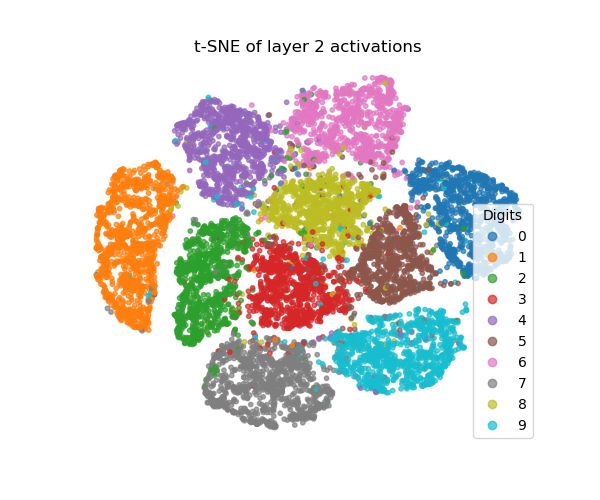

- Perplexity, $p=50$ and $1000$ iterations:
>Starting t-SNE...\
Finished in 21.795960187911987 seconds

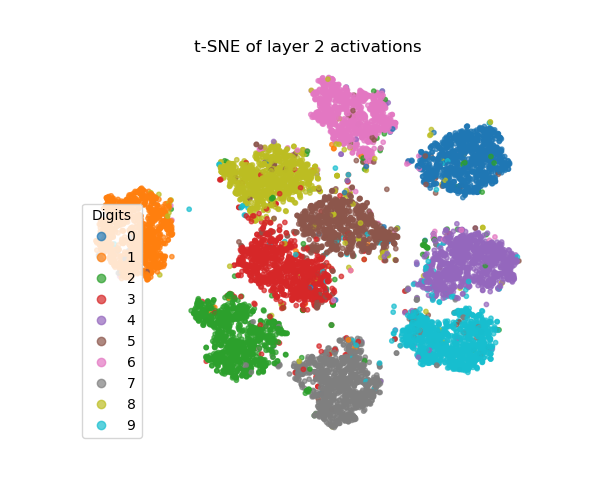

### 5.3 UMAP (still in Castillo's blog!)

Uniform Manifold Approximation and Projection, UMAP, is a dimensionality reduction method that is similar to t-SNE, but its differences make it more effiient to compute and a bit better at retaining both local and global structure of the data. 

Where t-SNE builds conditional probabilities and minimizes KL divergence, UMAP instead works with unnormalized similarities and minimizes a cross-entropy loss between the high and low-dimensional graphs. CE loss penalizes placing points close togther in the projection if they are far apart in the original space. 

> Once we get t-SNE working tomorrow, we’ll compare the two visually and see whether UMAP gives cleaner class separation or preserves broader structure more effectively.


In [125]:
import time
import umap

reducer = umap.UMAP(n_components=2)

print("Starting UMAP...")
start = time.time()
Proj_umap = reducer.fit_transform(acts)
print("Finished in", time.time() - start, "seconds")

Starting UMAP...
Finished in 13.460432052612305 seconds


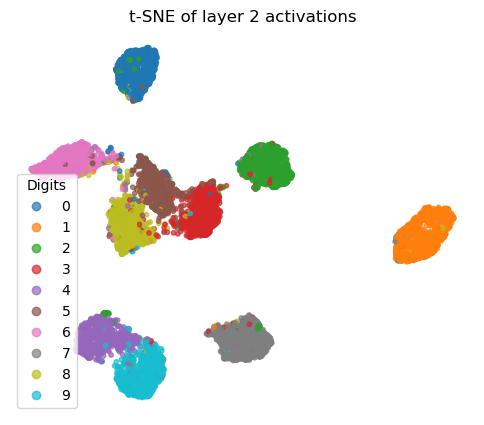

In [127]:
# NEXT STEP... (after the t-SNE runs... it is SLOW) plot like we did above:
plt.figure(figsize=(6, 5))
scatter = plt.scatter(Proj_umap[:, 0], Proj_umap[:, 1], c=ys, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title(f"t-SNE of layer 2 activations")
plt.axis('off')

plt.savefig('tsne_out.png')

As we can see, UMAP does a nice job of separating the data into distinct regions corresponding to different classes.

The most noticeable overlaps appear between:

- 3, 5, and 8 — digits with similar loopy structures
- 4 and 9 (and a bit with 7), which often share stroke patterns in handwritten form

These classes also happen to be the bottom 6 in terms of model accuracy, which suggests that the internal representation space may still be somewhat entangled for these digits. This overlap in the UMAP space provides some visual evidence for model's accuracy of certain classes and highlights the classes where the model performs poorly. 

> We suspect that normalization will provide even more distinct regions but only time will tell.

### 5.4. Final observations

We see that UMAP does a better job than t-SNE at separating the class clusters AND it makes it a bit more clear where the model likely struggles in its classifcation task. For example, 
- 4 and 9 are clearly entangled in this space
    - Given the models accuracy ranking and this visualization: we suspect the model might be more likely to classify a 9 as a 4. We look into this more in the next notebook.
-  0, and 1 lie quite far from each other and seem isolated in this space.
- The model seems to group classes based on features:
    - the 4,9 cluster also sees class 7 as a near(ish) neighbor
    - This phenomena is also highlighted in the center mass which lumps the classes 5, 8, and 3 together. 

In short, these visualization tools help us 'see' how data is arranged in the high dimensional spaces and it is not surpising that the model is less accuracy when this data is not well separated in these spaces. 

## 6. Reflections + future directions

The (restructured) goal of this notebook was to investigate why normalization matters and to explore how one might visualize and diagnose training behavior in a minimal MLP.

We built a simple, interpretable MLP trained on MNIST without input normalization, and tracked internal activations across layers and epochs. What we found:

  > - activations drift significantly with shifting means and growing variances.
  > - although the model achieved about 94% accuracy across training and testing data, there were some serious issues internally that likely hindered the trainnig and overall accuracy of the model.

This experiment gives us a concrete, interpretable reason to care about normalization: faster convergence, but also for controlling internal chaos.

We also introduced methods that allow us to take high dimensional representation spaces from within the model and project them onto a two dimensional space for visulization purposes. We observe that various failures of the model correspond to overlapping regions in these spaces, we investivate this in more detail in the next notebook. 

In the next notebook, we’ll investigate:

- Gradient tracking via hooks
- Detailed neuron analysis in the hidden layers
- Applying tools like PCA on neural subspaces to explore entanglement, and superposition.

Again, the goal is to build an interpretability toolbox—starting small, but scaling toward models where these tools become essential.